In [1]:
import pandas as pd
import json
# plotting
import os
import pathlib
import warnings
from joblib import load
from mplsoccer import Pitch
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Creating a Classifier model 

In [2]:
file_name = 'pos_chains_germany.json'

with open(file_name) as f:
    data = json.load(f)

df_germany = pd.DataFrame(data)

## Generating Variables

The features being fed to the model wil be non-linear combinations of x and c coordinate, distance from the centre line of the pitch.

In [3]:
var = ['x0', 'x1','c0','c1']

inputs = []

# 1 variable combination
inputs.extend(combinations_with_replacement(var,1))
# 2 variable combination
inputs.extend(combinations_with_replacement(var,2))
# 3 variable combination
inputs.extend(combinations_with_replacement(var,3))

In [4]:
#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df_germany[c]
        #create a new column in df
        df_germany[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df_germany[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,0.000000,0.000000,2.515456
1,35.216384,493.029376,6902.411264
2,986.058752,140.865536,20.123648


## Training Model

Will now use these new features to train an XGBoost Classifier on whether the start and end coordinates result in a shot

$$P(\text{shot}|x_0, c_0, x_1, c_1) = f(x_0, c_0, x_1, c_1)$$

In [5]:
# isolate passes in germany dataset

pass_germany = df_germany[df_germany['eventName'].isin(['Pass'])]
X = pass_germany[var]
y = pass_germany['shot_end']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1234)

DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)

params = {'objective':'binary:logistic', 'max_depth':4,'min_samples_leaf':10}

model_results = xgb.cv(dtrain=DM_train, params=params, num_boost_round = 100, as_pandas = True, nfold = 10)

In [6]:
model_xgb = xgb.train(dtrain=DM_train, params=params, num_boost_round = 100)
pred_probs = model_xgb.predict(DM_test)

pred_class = np.where(pred_probs > 0.5, 1, 0)

# calculating accuracy of the XGBoost Classifier model
acc_list = [1 if pred == label else 0 for pred, label in zip(pred_class, DM_test.get_label())]

accuracy = np.sum(acc_list) / len(acc_list)
print('Test Set Accuracy: {}'.format(accuracy))

Test Set Accuracy: 0.9243564784771793


Now have a classifier model that will predict the probability of a shot occuring based on the start and end points of the action. Will now train and evaluate a linear regression model on the german possession dataset to find the the probability of a goal occuring given the start and end coordinates of the event and if a shot was taken in the chain.
$$P(\text{goal}|\text{shot},x_0, c_0, x_1, c_1) = f(x_0, c_0, x_1, c_1)$$

In [7]:
passes_germany_shot_end = pass_germany[pass_germany['shot_end'] == 1]
X, y = passes_germany_shot_end[var], passes_germany_shot_end['xG']

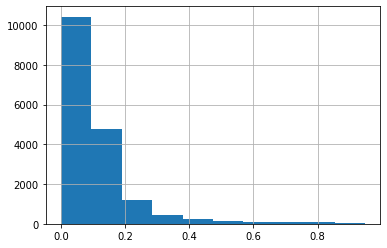

In [8]:
passes_germany_shot_end['xG'].hist()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

lr = LinearRegression()

lr.fit(X_train, y_train)

germany_xg_pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, germany_xg_pred, squared = False)

0.11144919165962838

### Implementing Model on English Dataset

In [10]:
# loading english dataframe possesssion chains

df_england = pd.DataFrame()
for i in range(11):
    file_name = 'possession_chains_England' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'action_xT', file_name)
    with open(path) as f:
        data = json.load(f)
    df_england = pd.concat([df_england, pd.DataFrame(data)], ignore_index = True)

df_england = df_england.reset_index()

Repeat the steps of generating variables for the english dataset again

In [11]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df_england[c]
        #create a new column in df
        df_england[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns


In [12]:
df_england[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752


Can now use the models trained on the Germany dataset for the English dataset. Begin by calculating the probability of a shot being taken

In [13]:
passes_england = df_england.loc[df_england["eventName"].isin(["Pass"])]

X_eng = passes_england[var]
y_eng = passes_england['shot_end']

DM_test_eng = xgb.DMatrix(data = X_eng, label = y_eng)
eng_pred_prob = model_xgb.predict(DM_test_eng)

In [14]:
passes_england['shot_prob'] = eng_pred_prob

Will now use the Linear regression model to find the predicted xG given a shot was taken and the beginning and end points of the action

In [15]:
X_eng_shot_end = passes_england[var]
y_eng_shot_end = passes_england['xG']

eng_pred_xg = lr.predict(X_eng_shot_end)

In [16]:
eng_pred_xg

array([0.12515031, 0.1156563 , 0.12819525, ..., 0.11657753, 0.16614263,
       0.17615509])

In [17]:
mean_squared_error(y_eng_shot_end, eng_pred_xg, squared = False)

0.10816087554475703

In [18]:
passes_england['xG_pred'] = eng_pred_xg

In [19]:
#calculate xGchain
passes_england["xT"] = passes_england["xG_pred"] * passes_england["shot_prob"]

passes_england[["xG_pred", "shot_prob", "xT"]].head(5)

,xG_pred,shot_prob,xT
0,0.125150,0.020564,0.002574
1,0.115656,0.034294,0.003966
2,0.128195,0.037753,0.004840
3,0.111881,0.038205,0.004274
4,0.115498,0.039909,0.004609


## Finding Players with the highest action based xT

In [20]:
summary = passes_england[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()

In [21]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding = 'unicode-escape')

# rename column so both dataframes can be merged on the same key
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)

# extract players role
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)

# isolate relevant columns to merge with summary datafrane
to_merge = player_df[['playerId', 'shortName', 'role']]

In [22]:
summary = summary.merge(to_merge, how = "left", on = ["playerId"])

In [23]:
# load players minutes dataframe

#get minutes
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'Data','Wyscout',"minutes_played", 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
# group by player and aggregrate by minutes played
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

# merge with summary dataframe on playerId and filter for players with more than 400 minutes
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

In [24]:
#calculating per 90
summary["xT_p90"] = summary["xT"]*90/summary["minutesPlayed"]

In [25]:
# adjusting xT per 90 for players possession

# load possession data
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'Data','Wyscout',"minutes_played", 'player_possesion_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)

In [26]:
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
#adjust per possesion
summary["xT_adjusted_per_90"] = (summary["xT"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
22,M. Özil,1.528043
27,Fàbregas,1.452204
250,E. Hazard,1.366834
30,A. Sánchez,1.363921
117,David Silva,1.328460
